<a href="https://colab.research.google.com/github/GiX7000/deep-learning-with-python/blob/main/DeepLearning_with_Python_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for text and sequences from the book 'Deep Learning with Python', Part 3, Francois Chollet

## Example 1. Working with text data: IMDB movie-review sentiment classification

Like all other NNs, dl models don't take as input raw text, but numeric tensors. Vectorizing is the process of transforming text into numeric tensors and can be done with: 1) segment text into words, and transform each word into a vector, 2) segment text into characters, and transform each character into a vector and 3) extract n-grams of words or characters, and transform each n-gram into a vector. Each different unit into which we break down text after segmentation is called token and the process is also called tokenization. So, to vectorize now these tokens, we have 2 ways: 1) one-hot encoding and 2) token/word embedding

1. One-hot encoding of words consists of associating a unique integer index with every word and then turning this integer index i into a binary vector of size N with all zeros except for the i-th entry, which is 1

In [1]:
# example of using keras to vectorize tokens: transform each word of a sentence into a vector, which will be input to NN
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words=1000)   # creates tokenizer taking into account the 1000 most common words=> each word in a sentence is a 1000D vector!
tokenizer.fit_on_texts(samples)   

sequences = tokenizer.texts_to_sequences(samples)   # turns the strings into lists of integers
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary') # returns an array of (2, 1000). there is 1 if the word is on 1000 most common words of tokenizer

word_index = tokenizer.word_index   # recover the word index that was computed
print('Found %s unique tokens.' %len(word_index))

Found 9 unique tokens.


2. Word embeddings is also a powerful way to associate a vector with a token/word. Word embeddings are dense, lower-dimensional and learned from data, whereas one-hot word vectors are sparse, high-dimensional and hardcoded

There are 2 ways to obtain word embeddings: 

2.1. Learn word embeddings with embedding layer, jointly with the main task we care about. Here, we start with random word vectors and then learn word vectors in the same way we learn the weights of a NN


In [2]:
# load the IMDB data. remember that the loaded data are already tokenized, so we only need to vectorize these tokens(words)
from keras.datasets import imdb

max_features = 10000    # restrict movie reviews to the top 10000 most common words
maxlen = 20   # limit text length to 20 words max

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)   # loads data as lists of integers

17464789/17464789 [==============================] - 0s 0us/step


In [3]:
# now, we want these lists of integers to have maximum 20 integers=> 20 words max at each review!
# so, the new shape of x_train and x_test would be (25000, 20)
from keras.utils import pad_sequences

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

So now, our datasets x_train and y_train, are comprised of 25000 samples(reviews) with 20 words(tokens) each. Each word is actually represented by an integer which declares the index of the word in a 10000 vocabulary with the most 10000 common words. All we want is the best vector representations(embeddings) of all of those words and that is why we train the embedding layer

In [4]:
# define model's architecture including an Embedding layer
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
# embedding layer takes as input 2D integer tensors(25000 samples with 20 words/features each)    
# output of embedding layer is a 3D floating-point tensor od shape (samples, sequence_length, embedding_dimensionality) -> here we have 8-dimensional embeddings for each of the 10000 words
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 8)             80000     
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 1)                 161       
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [5]:
# train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 7s 7ms/step - loss: 0.6736 - acc: 0.6126 - val_loss: 0.6266 - val_acc: 0.6996
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5462 - acc: 0.7499 - val_loss: 0.5263 - val_acc: 0.7330
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4613 - acc: 0.7882 - val_loss: 0.4993 - val_acc: 0.7488
Epoch 4/10
625/625 [==============================] - 5s 7ms/step - loss: 0.4199 - acc: 0.8095 - val_loss: 0.4921 - val_acc: 0.7566
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3929 - acc: 0.8245 - val_loss: 0.4923 - val_acc: 0.7558
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3719 - acc: 0.8352 - val_loss: 0.4969 - val_acc: 0.7572
Epoch 7/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3540 - acc: 0.8450 - val_loss: 0.5022 - val_acc: 0.7554
Epoch 8/10
625/625 [==============================] - 3s 5ms/step - loss: 0.

An almost 76% validation accuracy and by only taking into account 20 words at each review. This approach is also without considering inter-word relationships and sentence structure, like recurrent networks do

In [6]:
# if you don't have to compare this model to other models, evaluate on your test set
model.evaluate(x_test, y_test)

782/782 [==============================] - 4s 5ms/step - loss: 0.5141 - acc: 0.7606


[0.5140745043754578, 0.760640025138855]

2.2. Learn word embedding by using pretrained word embeddings

When we have so little data available, instead of learning word embeddings jointly with the problem we want to solve, we load embedding vectors from a precomputed embedding space that we know is highly structured and exhibits useful properties

Instead of using pretokenized data from imdb, we download here the original text data, which is comprised of 2 folders pos and neg with reviews in txt files

In [7]:
# get and unzip raw text data
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  25.0M      0  0:00:03  0:00:03 --:--:-- 25.0M


In [8]:
# collect review labels(pos/neg) into a label list(1/0) as well as reviews in a text list
import os

imdb_dir = '/content/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []   # list of labels of reviews
texts = []    # list of texts/reviews

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

We said we use this approach when we have little data, so we restrict the training data to the first 200 samples

In [9]:
# tokenizing the data
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import numpy as np

maxlen = 100    # we cut reviews with more than 100 words
training_samples = 200
validation_samples = 10000
max_words = 10000   # considers only the top 10000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)   # every word is a token(an integer-index in a 10000 most common words space) now in a sentence
word_index = tokenizer.word_index
print('Found %s unique tokens.' %len(word_index))

Found 88582 unique tokens.


In [10]:
# prepare the data
data = pad_sequences(sequences, maxlen=maxlen)    # all reviews at 100 words

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)    # data are ordered to all negatives first and then all positives, as we did it inthe fro loop above. so we need to shuffle 
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples : training_samples + validation_samples]
y_val = labels[training_samples : training_samples + validation_samples]

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


We will use the precomputed GloVe word embeddings

In [11]:
# get and unzip pretrained word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-11-30 10:21:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-11-30 10:21:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-11-30 10:21:12--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [12]:
# parsing the GloVe embeddings file
glove_dir = '/content'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [13]:
# word embeddings matrix. is matrix of shape(max_words, embedding_dim)
# each entry-token i contains a embedding_dim-dimensional vector for the word of index i 
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i<max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector    # words not found in the embeddings_index will be all 0

In [14]:
# define the model
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_1 (Dense)             (None, 32)                320032    
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


Weights of the embedding layer would be the weights from embedding matrix, which contains the pretrained word embeddings from glove.6B.100d

In [15]:
# set pretrained word embeddings weights as the weights of our Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False   # here, we have fed the embedding layer with pretrained weights and we feeze it in order not to change these weights. This was, actually, our initial purpose: to use that pretrained weights!

In [16]:
# compile, train and save the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 2s 288ms/step - loss: 2.6130 - acc: 0.4400 - val_loss: 0.8578 - val_acc: 0.5020
Epoch 2/10
7/7 [==============================] - 1s 110ms/step - loss: 0.4928 - acc: 0.7550 - val_loss: 1.3306 - val_acc: 0.4998
Epoch 3/10
7/7 [==============================] - 1s 100ms/step - loss: 0.4473 - acc: 0.7650 - val_loss: 1.1298 - val_acc: 0.5014
Epoch 4/10
7/7 [==============================] - 1s 109ms/step - loss: 0.3665 - acc: 0.8300 - val_loss: 0.7074 - val_acc: 0.5628
Epoch 5/10
7/7 [==============================] - 1s 99ms/step - loss: 0.1730 - acc: 0.9700 - val_loss: 1.3865 - val_acc: 0.5001
Epoch 6/10
7/7 [==============================] - 1s 100ms/step - loss: 0.2010 - acc: 0.9200 - val_loss: 0.8002 - val_acc: 0.5406
Epoch 7/10
7/7 [==============================] - 1s 151ms/step - loss: 0.0876 - acc: 0.9950 - val_loss: 0.7932 - val_acc: 0.5503
Epoch 8/10
7/7 [==============================] - 1s 101ms/step - loss: 0.2978 - acc: 0.870

An almost 58% validation accuracy here, and we keep it to compare with validation's accuracy of the next model

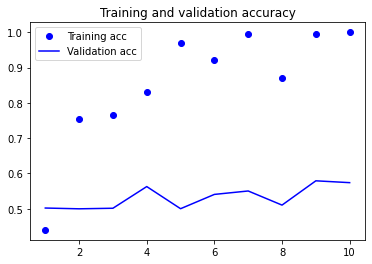

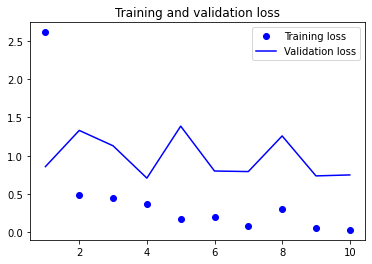

In [17]:
# plot the results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The model overfits, which is unsurprising given the small number of training set with just 200 samples

Now, let's see the performance of a model that is trained without pretrained word embeddings

In [18]:
# define a model
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_3 (Dense)             (None, 32)                320032    
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 1s 130ms/step - loss: 0.6977 - acc: 0.4600 - val_loss: 0.6937 - val_acc: 0.5093
Epoch 2/10
7/7 [==============================

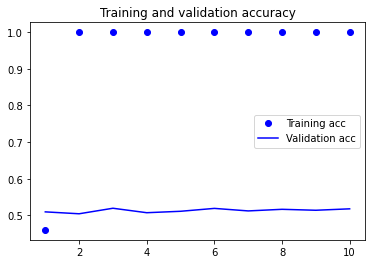

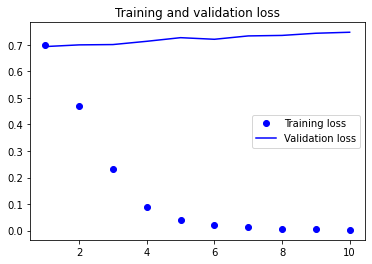

In [19]:
# plots of results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

This model's accuracy, almost 52%, is worse than the previous one, so we finally choose the previous model to make our predictions

Now, after choosing the best model, we need to evaluate on test set. To do that, we should bring the test data into the apropriate form, like we did earlier for the training data

In [20]:
# tokenizing the test data
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(test_dir, label_type)
  for fname in sorted(os.listdir(dir_name)):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [21]:
# evaluate the previous and better model on the test set
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 7s 9ms/step - loss: 0.7559 - acc: 0.5690


[0.755906343460083, 0.5690400004386902]

## Example 2. IMDB movie-review sentiment classification with RNNs

RNNs process sequences by iterating through the sequence elements and maintaining a state containing information relative to what it has seen so far. A RNN takes as input a sequence of vectors (timesteps, input_features) and it loops over timesteps, and at each timestep, it considers its current state at t and the input at t(shape of input_features), and combines them to obtain the output at t. Its initial state is an all 0 vector. Its output is a 2D tensor of shape (timesteps, output_features)(all @page 198) 

Preparing the IMDB data

In [22]:
# load the IMDB data. remember that the loaded data are already tokenized, so we only need to vectorize these tokens(words)
from keras.datasets import imdb
from keras.utils import pad_sequences

max_features = 10000  # number of words considered as features
maxlen = 500  # keep texts with maximum 500 words
batch_size = 32

print('Loading data ...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)  # the data here is already tokenized
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('\nPad sequences (samples x time)')
input_train = pad_sequences(input_train, maxlen)
input_test = pad_sequences(input_test, maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data ...
25000 train sequences
25000 test sequences

Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Train a model with embedding and simpleRNN layers

In [23]:
# define, compile and train the model
from keras.layers import SimpleRNN

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))  # returns only the output for each input sequence: 2D tensor of shape (batch_size, output_feature)
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 151s 952ms/step - loss: 0.6130 - acc: 0.6496 - val_loss: 0.4681 - val_acc: 0.7920
Epoch 2/10
157/157 [==============================] - 153s 976ms/step - loss: 0.3943 - acc: 0.8349 - val_loss: 0.3648 - val_acc: 0.8516
Epoch 3/10
157/157 [==============================] - 151s 963ms/step - loss: 0.2916 - acc: 0.8845 - val_loss: 0.4728 - val_acc: 0.7708
Epoch 4/10
157/157 [==============================] - 153s 975ms/step - loss: 0.2363 - acc: 0.9093 - val_loss: 0.4061 - val_acc: 0.8212
Epoch 5/10
157/157 [==============================] - 175s 1s/step - loss: 0.1949 - acc: 0.9251 - val_loss: 0.4537 - val_acc: 0.8098
Epoch 6/10
157/157 [==============================] - 158s 1s/step - loss: 0.1341 - acc: 0.9520 - val_loss: 0.4697 - val_acc: 0.8210
Epoch 7/10
157/157 [==============================] - 157s 1s/step - loss: 0.0864 - acc: 0.9704 - val_loss: 0.5143 - val_acc: 0.8282
Epoch 8/10
157/157 [==============================] - 147

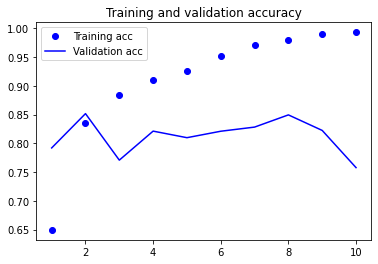

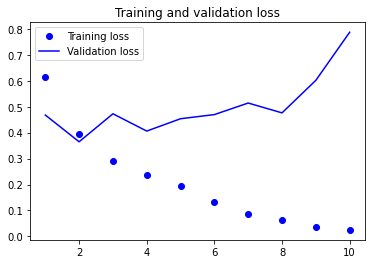

In [24]:
# plotting results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As we can see, this model achieves a validation accuracy of almost 76%. Let's try to improve it by using more powerful RNNs

In practice, such long-term dependencies(simpleRNN) are impossible to learn, and as we keep adding layers to a network, the network eventually becomes untrainable(vanishing gradient problem). LSTMs and GRUs are designed to solve this problem(@page202): they allow past information to be reinjected at a later time, thus fighting the vanishing-gradient problem

Using the LSTM layer 

In [ ]:
# define, compile and train the new model
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))  # returns only the output for each input sequence: 2D tensor of shape (batch_size, output_feature)
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 26s 123ms/step - loss: 0.5071 - acc: 0.7619 - val_loss: 0.4975 - val_acc: 0.7534
Epoch 2/10
157/157 [==============================] - 6s 41ms/step - loss: 0.2989 - acc: 0.8798 - val_loss: 0.3575 - val_acc: 0.8614
Epoch 3/10
157/157 [==============================] - 11s 72ms/step - loss: 0.2362 - acc: 0.9104 - val_loss: 0.3068 - val_acc: 0.8810
Epoch 4/10
157/157 [==============================] - 14s 93ms/step - loss: 0.1995 - acc: 0.9252 - val_loss: 0.3495 - val_acc: 0.8552
Epoch 5/10
157/157 [==============================] - 10s 67ms/step - loss: 0.1765 - acc: 0.9360 - val_loss: 0.3152 - val_acc: 0.8812
Epoch 6/10
157/157 [==============================] - 7s 44ms/step - loss: 0.1570 - acc: 0.9454 - val_loss: 0.3778 - val_acc: 0.8790
Epoch 7/10
157/157 [==============================] - 13s 81ms/step - loss: 0.1454 - acc: 0.9493 - val_loss: 0.3220 - val_acc: 0.8648
Epoch 8/10
157/157 [==============================] - 10s 67ms/

In [29]:
# save the model
model.save_weights('model_with_lstm')

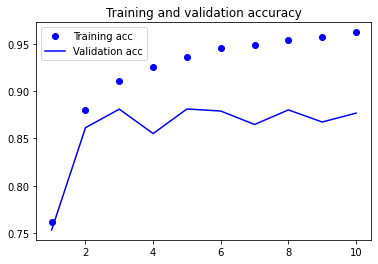

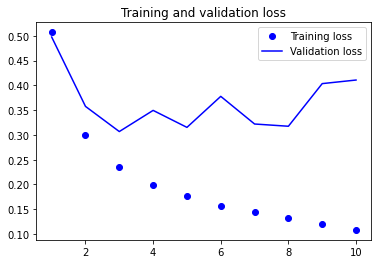

In [ ]:
# and the plots now
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

With a LSTM layer, we achieve a better validation accuracy(88%), beacause LSTM suffers less from the vanishing-gradient problem. Further actions like adding regularization and hyperparameter tuning can improve accuracy

Using a Bidirectional RNN

In [25]:
# reverse sequences
input_train = [x[::-1] for x in input_train]
input_test = [x[::-1] for x in input_test]

# and then pad these sequences
input_train = pad_sequences(input_train, maxlen)
input_test = pad_sequences(input_test, maxlen)

In [26]:
# define, compile and train the new model with bidirectional LSTM
from keras import layers

model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))  
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 24s 110ms/step - loss: 0.5462 - acc: 0.7266 - val_loss: 0.3827 - val_acc: 0.8434
Epoch 2/10
157/157 [==============================] - 22s 141ms/step - loss: 0.3324 - acc: 0.8678 - val_loss: 0.3331 - val_acc: 0.8652
Epoch 3/10
157/157 [==============================] - 18s 116ms/step - loss: 0.2463 - acc: 0.9062 - val_loss: 0.4665 - val_acc: 0.8438
Epoch 4/10
157/157 [==============================] - 18s 113ms/step - loss: 0.2139 - acc: 0.9201 - val_loss: 0.3604 - val_acc: 0.8748
Epoch 5/10
157/157 [==============================] - 13s 80ms/step - loss: 0.1861 - acc: 0.9320 - val_loss: 0.3642 - val_acc: 0.8594
Epoch 6/10
157/157 [==============================] - 20s 126ms/step - loss: 0.1636 - acc: 0.9419 - val_loss: 0.3064 - val_acc: 0.8854
Epoch 7/10
157/157 [==============================] - 15s 99ms/step - loss: 0.1464 - acc: 0.9487 - val_loss: 0.3285 - val_acc: 0.8864
Epoch 8/10
157/157 [==============================] - 20s

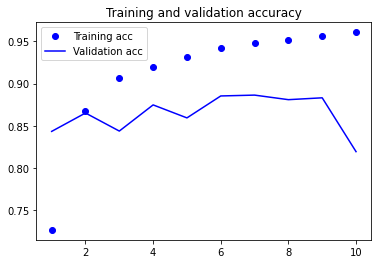

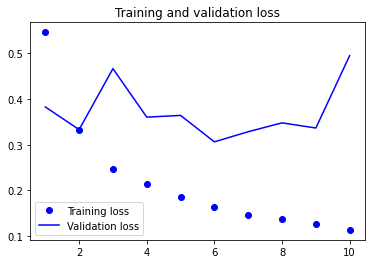

In [27]:
# plotting results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We observe that the model with a LSTM layer performs the best, even from that one with a bidirectional layer. Obviously, we need to try more things to improve this model's accuracy

## Example 3. Air temperature-forecasting

Some advanced techniques to improve the performance and generalization power of RNNs: 1) recurrent dropout, 2) staking recurrent layers and 3) bidirectional recurrent layers

Load the data 

In [3]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-11-30 13:23:27--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.229.184, 52.216.139.141, 52.217.50.62, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.229.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  39.8MB/s    in 0.3s    

2022-11-30 13:23:28 (39.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [4]:
# Jena weather dataset exploring
import os
fname = os.path.join("jena_climate_2009_2016.csv")

f = open(fname)
data = f.read()
f.close()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Now, we need to convert all these numerical values into a numpy array

In [5]:
# parsing the data
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

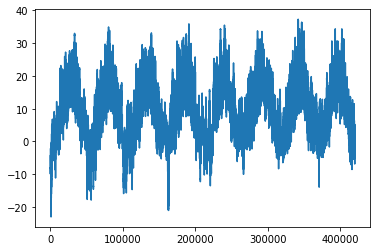

In [6]:
# plot the temperature timeseries
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

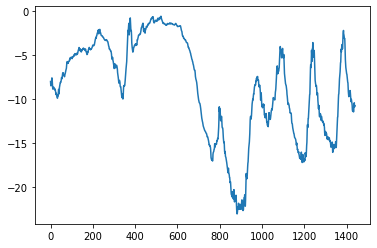

In [7]:
# plot the first 10 days of the temperature timeseries @page209
plt.plot(range(1440), temperature[:1440])

In [8]:
# do you know how many data we have?
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


Prepare the data

The data are already numerical, so we don't need to do any vectorization here. Because there are flactuations in values of different features, we will normalize these values. We will also create batches of data instead of float data with a generator

In [9]:
# normalize the data
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Instead of using a custom generator approach, like the book does, we will better use keras.utils.timeseries_dataset_from_array to transform the data to the appropriate form





In [10]:
# transform a timeseries dataset
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [11]:
# prepare the training, validation and test timeseries datasets
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [12]:
# inspect the output of one of the above created datasets
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


When we are approaching a problem for which there is no known solution, we use our common-sense baseline. For example, here we want to predict a continuous value, the temperature, and we will use mae as a metric

In [13]:
# computing the common-sense baseline MAE
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Model 1: a basic NN

In [15]:
# define, compile and train the model 1
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
model.summary()

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 flatten_1 (Flatten)         (None, 1680)              0         
                                                                 
 dense_2 (Dense)             (None, 16)                26896     
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
819/819 [==============================] - 53s 64ms/step - loss: 14.3782 - mae: 2.9201 - val_loss: 12.3174 - val_mae: 2.7628
Epoch 2/10
819/819 [==============================]

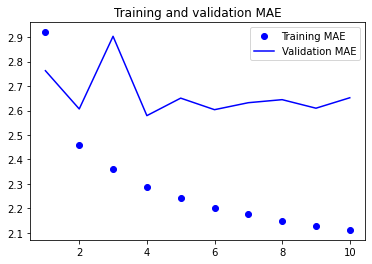

In [16]:
# plotting results of model 1
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Model 2: a GRU based model

In [26]:
# define, compile and train the model 2
from keras.models import Sequential

model = Sequential()
model.add(layers.GRU(32, input_shape=(sequence_length, raw_data.shape[-1])))
model.add(layers.Dense(1))
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 32)                4608      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 32)                4608      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,641
Trainable para

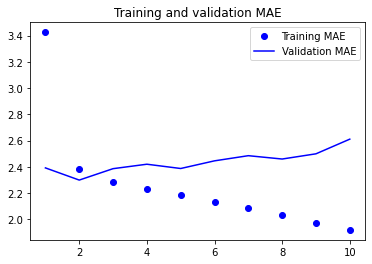

In [27]:
# plotting results of model 2
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Model 3: a dropout-regularized GRU based model

In [28]:
# define, compile and train the model 3
model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(sequence_length, raw_data.shape[-1])))
model.add(layers.Dense(1))
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dropout_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 32)                4608      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
819/819 [==============================] - 277s 335ms/step - loss: 25.2598 - mae: 3.5995 - val_loss: 9.6161 - val_mae: 2.3950
Epoch 2/10
819/819 [==============================] - 270s 330ms/step - loss: 10.2187 - mae: 2.5070 - val_loss: 9.9633 - val_mae: 2.4017
Epoch 3/10
819/819 [==============================] - 277s 338ms/step - loss: 9.6516 - mae: 2.4364 - val_loss: 9.8280 - val_mae: 2.3961
Epoch 4/10
819/819 [==================

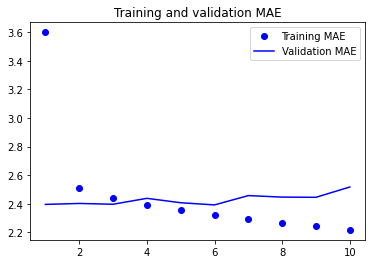

In [30]:
# plotting results of model 3
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Model 4: staking recurrent layers

In [31]:
# define, compile and train the model 4
model = Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5,return_sequences=True, input_shape=(sequence_length, raw_data.shape[-1])))
model.add(layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_staking_grus.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 120, 32)           4608      
                                                                 
 gru_4 (GRU)                 (None, 64)                18816     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 23,489
Trainable params: 23,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
819/819 [==============================] - 663s 803ms/step - loss: 14.7390 - mae: 2.8904 - val_loss: 9.2574 - val_mae: 2.3472
Epoch 2/10
819/819 [==============================] - 655s 800ms/step - loss: 9.7494 - mae: 2.4462 - val_loss: 9.3203 - val_mae: 2.3559
Epoch 3/10
819/819 [=====================

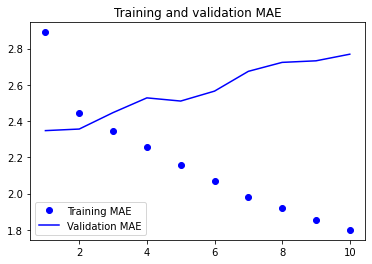

In [32]:
# plotting results of model 4
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Model 5: a bidirectional GRU model

In [34]:
# define, compile and train the new model with bidirectional GRU
from keras import layers

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(sequence_length, raw_data.shape[-1])))  # you can also try LSTM instead of GRU
model.add(layers.Dense(1))
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bd_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 64)               9216      
 l)                                                              
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,281
Trainable params: 9,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
819/819 [==============================] - 269s 323ms/step - loss: 16.8814 - mae: 2.9996 - val_loss: 8.8954 - val_mae: 2.3166
Epoch 2/10
819/819 [==============================] - 265s 323ms/step - loss: 8.7635 - mae: 2.3106 - val_loss: 9.0958 - val_mae: 2.3292
Epoch 3/10
819/819 [==============================] - 265s 323ms/step - loss: 7.7231 - mae: 2.1713 - val_loss

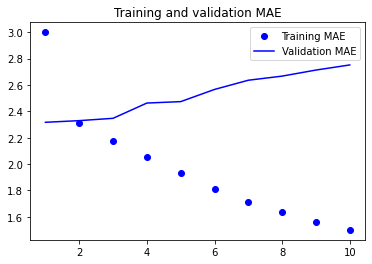

In [35]:
# plotting results of model 5
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

The third model achieves the highest validation accuracy, so we keep it as our best choice. If we add some more layers to last model, maybe, it would perform better. Generally, a lot of combinations between different layers can be done

In [39]:
# evaluate the best performing model on the test set
model = keras.models.load_model("jena_dropout_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 66s 159ms/step - loss: 10.0209 - mae: 2.4886
Test MAE: 2.49


What to try here:
*   adjust the number of units in each recurrent layer in the stacked setup
*   adjust the learning rate
*   try LSTMs instead of GRUs, and, generally, try different combinations between different layers
*   try bigger Dense layers on top of the model
*   try retrain a model for this number of epoch that the model starts to overfit
*   don't forget to run/evaluate the best performing model on your test set(we use validation to compare models between each other)







Some tips from here:
*   try simple models before expensive ones
*   when you have data where temporal ordering matters, use RNNs
*   stacked RNNs provide more representational power, but they are more expensive than single RNNs
*   when approaching a new problem, first establish common-sense baselines for your metric of choice



## Example 4. Sequence processing with ConvNets

Small 1D convnets can offer a fast alternative to RNNs for simple tasks such as text classification and timeseries forecasting(@page225)

Model 1: with a simple 1D convnet for IMDB movie-review sentiment classification

We will use the same data as in example 2

In [ ]:
# load the IMDB data. remember that the loaded data are already tokenized, so we only need to vectorize these tokens(words)
from keras.datasets import imdb
from keras.utils import pad_sequences

max_features = 10000  # number of words considered as features
maxlen = 500  # keep texts with maximum 500 words
batch_size = 32

print('Loading data ...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)  # the data here is already tokenized
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('\nPad sequences (samples x time)')
input_train = pad_sequences(input_train, maxlen)
input_test = pad_sequences(input_test, maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data ...
25000 train sequences
25000 test sequences

Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [ ]:
# define, compile and train the model
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=maxlen))
model.add(layers.Conv1D(32, 7, activation='relu'))  
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_7 (Dense)             (None, 1)                

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


157/157 [==============================] - 9s 18ms/step - loss: 0.7168 - acc: 0.5354 - val_loss: 0.6829 - val_acc: 0.5744
Epoch 2/10
157/157 [==============================] - 6s 41ms/step - loss: 0.6633 - acc: 0.6704 - val_loss: 0.6625 - val_acc: 0.6318
Epoch 3/10
157/157 [==============================] - 5s 30ms/step - loss: 0.6225 - acc: 0.7485 - val_loss: 0.6096 - val_acc: 0.7454
Epoch 4/10
157/157 [==============================] - 6s 38ms/step - loss: 0.5352 - acc: 0.8006 - val_loss: 0.5028 - val_acc: 0.7962
Epoch 5/10
157/157 [==============================] - 4s 23ms/step - loss: 0.4296 - acc: 0.8371 - val_loss: 0.4401 - val_acc: 0.8296
Epoch 6/10
157/157 [==============================] - 5s 30ms/step - loss: 0.3565 - acc: 0.8665 - val_loss: 0.4172 - val_acc: 0.8462
Epoch 7/10
157/157 [==============================] - 3s 19ms/step - loss: 0.3139 - acc: 0.8879 - val_loss: 0.4208 - val_acc: 0.8568
Epoch 8/10
157/157 [==============================] - 8s 50ms/step - loss: 0.282

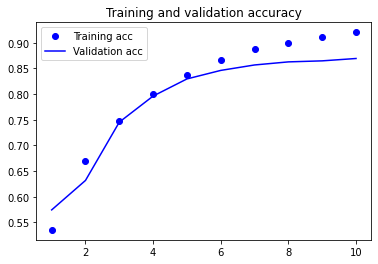

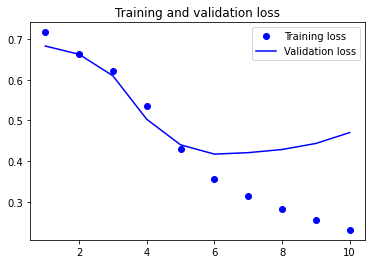

In [ ]:
# plotting the results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

This model is much faster, but with slightly less validation accuracy than the one in example 2 with a LSTM layer

Model 2: with a simple 1D convnet for air temperature forecasting on Jena dataset

We will use the same dataset as in example 3

In [17]:
# define, compile and train the model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
model.summary()
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 139s 168ms/step - loss: 26.1915 - mae: 3.9010 - val_loss: 16.4550 - val_mae: 3.2342
Epoch 2/10
819/819 [==============================] - 148s 180ms/step - loss: 15.6877 - mae: 3.1495 - val_loss: 15.3298 - val_mae: 3.0978
Epoch 3/10
819/819 [==============================] - 137s 166ms/step - loss: 14.5435 - mae: 3.0295 - val_loss: 15.8391 - val_mae: 3.1292
Epoch 4/10
819/819 [==============================] - 126s 153ms/step - loss: 13.7867 - mae: 2.9429 - val_loss: 15.5411 - val_mae: 3.0978
Epoch 5/10
819/819 [==============================] - 135s 165ms/step - loss: 13.2306 - mae: 2.8815 - val_loss: 17.4804 - val_mae: 3.3396
Epoch 6/10
819/819 [==============================] - 136s 166ms/step - loss: 12.7751 - mae: 2.8296 - val_loss: 14.4297 - val_mae: 2.9957
Epoch 7/10
819/819 [==============================] - 135s 164ms/step - loss: 12.3512 - mae: 2.7826 - val_loss: 15.0060 - val_mae: 3.0443
Epoch 8/10
819/819 [==============

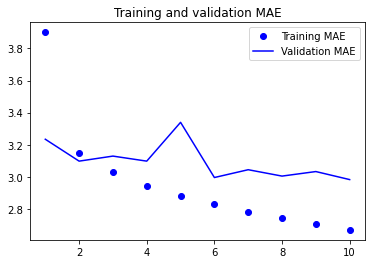

In [18]:
# plotting results 
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Model 3: combining Conv1D and GRU layers for air temperature forecasting on Jena dataset

In [20]:
# define, compile and train the model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.GRU(32, dropout=0.1, recurrent_dropout=0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv_plus_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
model.summary()
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 97, 8)             2696      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 48, 8)            0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 37, 8)             776       
                                                                 
 gru (GRU)                   (None, 32)                4032      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                           

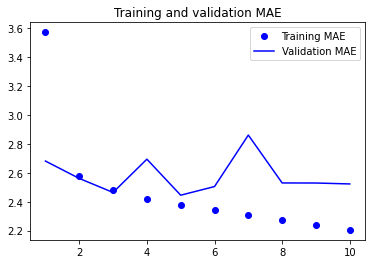

In [22]:
# plotting the results
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

As you see this model achieves a better performance than the previous one by just replacing a set of Conv1D-MaxPooling layers with a GRU layer. And, generally, we can experiment with several compinations in order to find better models 

In [23]:
# last step is to evaluate the model with the highest valisation accuracy on the test set
model = keras.models.load_model("jena_conv_plus_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 38s 91ms/step - loss: 11.1712 - mae: 2.6292
Test MAE: 2.63


1D convnets are cheap and perform well for processing temporal patterns and they offer a faster alternative to RNNs on some problems. It is a good idea to use a 1D convnet as a preprocessing step before the RNN, because RNNs are extremely expensive for processing very long sequences